<a href="https://colab.research.google.com/github/1uch0/LLM_Udemy_course/blob/main/LLM_chatgptmini_toMakePricePredictionFromDescription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [1]:
# imports
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
import sys
import re
import math
import json
import random
from huggingface_hub import login

sys.path.append('/content/drive/MyDrive/Colab Notebooks/LLM Engineering course/')
from google.colab import userdata

from items import Item
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI

Mounted at /content/drive


In [2]:
#"#$"$#"$#"$3hf_XaFGnopGYanqZomVsmfcOXpGGbpdgXNKJS$#%$#%$#%$#&%$#$!"#!"$%#"%$#"
#hf_token = os.environ['HF_TOKEN']
#login(hf_token, add_to_git_credential=True)
login()

In [3]:
# OpenAI API Key (Replace with your own key)

api_key = userdata.get('Open_AI_API') ##Open_AI_API It is the API key from OPEN_AI saved in your collab
openai = OpenAI(api_key=api_key)
openai_api_key = api_key


In [10]:
# Let's avoid curating all our data again! Load in the pickle files:

# Define the path to your pickle files, relative to your Google Drive mount point.
pickle_file_path = '/content/drive/MyDrive/Colab Notebooks/LLM Engineering course/'

with open(os.path.join(pickle_file_path, 'train.pkl'), 'rb') as file:
    train = pickle.load(file)

with open(os.path.join(pickle_file_path, 'test.pkl'), 'rb') as file:
    test = pickle.load(file)

In [11]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [12]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [13]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [14]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages_for(item),
        #Sometimes the model will change the seed will change
        seed=42,
        #max tokens
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [15]:
gpt_4o_mini(test[0])

180.0

In [16]:
test[0].price

374.41

1: Guess: $180.00 Truth: $374.41 Error: $194.41 SLE: 0.53 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.99 Truth: $61.68 Error: $15.69 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.99 Truth: $16.99 Error: $13.00 SLE: 0.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $49.99 Truth: $101.79 Error: $51.80 SLE: 0.49 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $239.00 Truth: $289.00 Error: $50.00 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10 

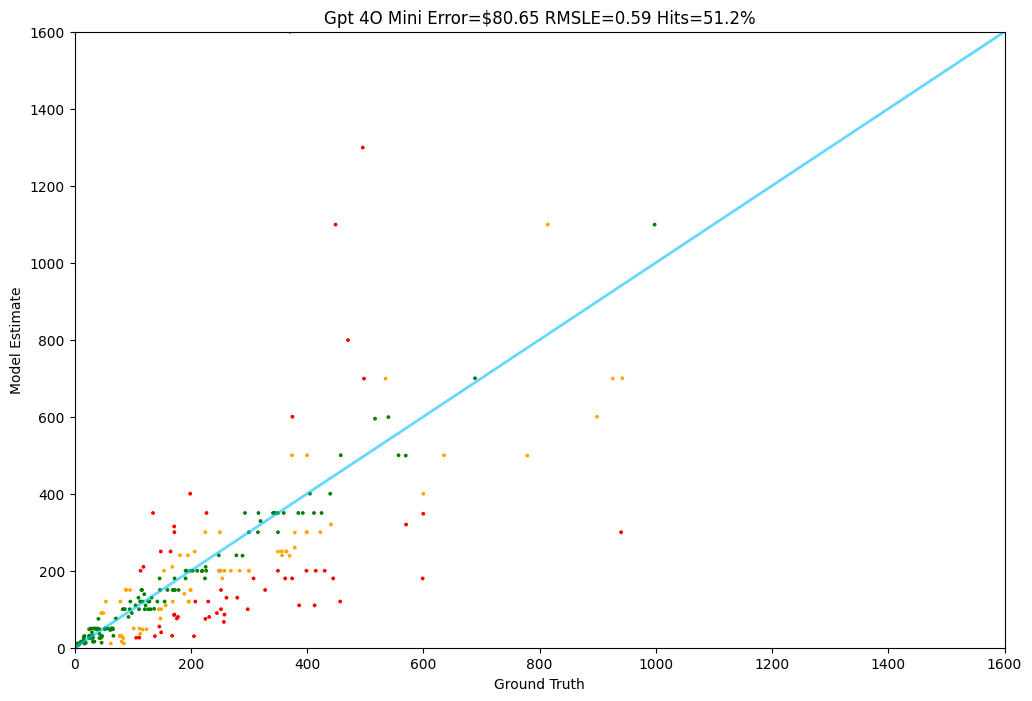

In [17]:
Tester.test(gpt_4o_mini, test)